**Dataset:** `students_mental_health_survey.csv`

**Variável Alvo:** `Depression_Score`

**Variáveis Preditoras Selecionadas (para o Modelo):**
* `Semester_Credit_Load` (Numérica)
* `Sleep_Quality` (Ordinal: Poor=0, Average=1, Good=2)
* `Course` (Nominal: One-Hot Encoded)
* `Financial_Stress` (Numérica: 0-5)
* `Physical_Activity` (Ordinal: Low=0, Moderate=1, High=2)
* `Diet_Quality` (Ordinal: Poor=0, Average=1, Good=2)
* `Social_Support` (Ordinal: Low=0, Moderate=1, High=2)
* `CGPA` (Numérica)

**Modelo Base:** Regressão Linear Múltipla

In [1]:
# Importar bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
import warnings

# Configurações
warnings.filterwarnings('ignore') # Ignorar avisos
plt.rcParams['figure.figsize'] = [12, 6] # Tamanho padrão das figuras
pd.set_option('display.max_columns', None) # Mostrar todas as colunas
pd.set_option('display.width', 1000) # Largura maior para display
sns.set_style('whitegrid') # Estilo dos gráficos

## 1. Carregamento e Limpeza Inicial dos Dados

Carregamos o dataset e removemos as linhas com valores ausentes.

Certificar de fazer o upload do arquivo antes de executar.

In [2]:
# --- Carregar o Dataset ---
file_path = 'students_mental_health_survey.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Dataset '{file_path}' carregado com sucesso.")
    print(f"Dimensões originais: {df.shape[0]} linhas, {df.shape[1]} colunas")
except FileNotFoundError:
    print(f"Erro Crítico: Arquivo '{file_path}' não encontrado.")
    print("Por favor, faça o upload do arquivo CSV (menu lateral esquerdo -> Arquivos -> Upload).")
    raise SystemExit("Arquivo não encontrado.")
except Exception as e:
    print(f"Erro inesperado ao carregar o arquivo: {e}")
    raise SystemExit("Erro no carregamento.")


Dataset 'students_mental_health_survey.csv' carregado com sucesso.
Dimensões originais: 7022 linhas, 20 colunas


In [3]:
# --- Inspeção Inicial Rápida ---
print("\nCabeçalho (5 primeiras linhas):")
display(df.head())
print("\nInfo Inicial:")
df.info()


Cabeçalho (5 primeiras linhas):


,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,19,Computer Science,Male,3.65,2,1,0,Average,Low,Average,Moderate,Single,NaN,Never,No,No,4,Moderate,20,Off-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus



Info Inicial:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          7022 non-null   int64  
 1   Course                       7022 non-null   object 
 2   Gender                       7022 non-null   object 
 3   CGPA                         7010 non-null   float64
 4   Stress_Level                 7022 non-null   int64  
 5   Depression_Score             7022 non-null   int64  
 6   Anxiety_Score                7022 non-null   int64  
 7   Sleep_Quality                7022 non-null   object 
 8   Physical_Activity            7022 non-null   object 
 9   Diet_Quality                 7022 non-null   object 
 10  Social_Support               7022 non-null   object 
 11  Relationship_Status          7022 non-null   object 
 12  Substance_Use                7007 non-null   object 
 13  Cou

In [4]:
# --- Tratamento de Valores Ausentes (Remoção) ---
missing_before = df.isnull().sum().sum()
print(f"\nTotal de valores ausentes: {missing_before}")
if missing_before > 0:
    print("Colunas com valores ausentes:")
    missing_counts_before = df.isnull().sum()
    print(missing_counts_before[missing_counts_before > 0].to_markdown())

    initial_rows = df.shape[0]
    df.dropna(inplace=True) # Remove linhas com NaN
    rows_removed = initial_rows - df.shape[0]
    print(f"\n{rows_removed} linhas foram removidas.")
else:
    print("\nNenhum valor ausente encontrado inicialmente.")

print(f"Novas dimensões do DataFrame: {df.shape}")
df.reset_index(drop=True, inplace=True) # Reseta o índice após remover linhas


Total de valores ausentes: 27
Colunas com valores ausentes:
|               |   0 |
|:--------------|----:|
| CGPA          |  12 |
| Substance_Use |  15 |

27 linhas foram removidas.
Novas dimensões do DataFrame: (6995, 20)


## 2. Pré-processamento: Conversão de Tipos e Codificação

Convertemos colunas para tipos numéricos apropriados e aplicamos as codificações definidas (Ordinal e One-Hot).

In [5]:
# --- Conversão de Tipos Numéricos ---
print("Convertendo tipos de dados numéricos...")
numeric_cols_to_convert = [
    'Age', 'CGPA', 'Stress_Level', 'Depression_Score',
    'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load'
]
conversion_errors = []
for col in numeric_cols_to_convert:
    if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
        print(f"Tentando converter '{col}' (atual: {df[col].dtype})...", end='')
        try:
            # Tratar vírgula decimal em CGPA
            if col == 'CGPA' and df[col].dtype == 'object' and df[col].astype(str).str.contains(',').any():
                 df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
                 print(f" -> float (tratou vírgula)")
            elif col == 'CGPA':
                 df[col] = pd.to_numeric(df[col], errors='raise')
                 print(f" -> {df[col].dtype}")
            else:
                df[col] = pd.to_numeric(df[col], errors='raise', downcast='integer')
                print(f" -> {df[col].dtype}")
        except Exception as e:
             print(f" -> ERRO: {e}")
             conversion_errors.append(col)
    elif col in df.columns:
         print(f"Coluna '{col}' já é numérica ({df[col].dtype}).")

if conversion_errors:
    print(f"\nAtenção: Falha na conversão das colunas: {conversion_errors}")
else:
    print("\nConversão de tipos numéricos bem-sucedida.")

# --- Codificação de Variáveis Categóricas ---
print("\nCodificando variáveis categóricas...")

# Ordinal Encoding para variáveis com ordem
print("  Aplicando Ordinal Encoding...")
sleep_order = ['Poor', 'Average', 'Good']
activity_order = ['Low', 'Moderate', 'High']
diet_order = ['Poor', 'Average', 'Good']
support_order = ['Low', 'Moderate', 'High']

ordinal_cols = ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support']
categories_list = [sleep_order, activity_order, diet_order, support_order]

if all(col in df.columns for col in ordinal_cols):
    try:
        ordinal_encoder = OrdinalEncoder(categories=categories_list)
        df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])
        print("    ✅ Variáveis ordinais codificadas. Mapeamento:")
        for i, col in enumerate(ordinal_cols):
           print(f"      {col}: {ordinal_encoder.categories_[i]} -> [0, 1, 2]")
    except ValueError as e:
        print(f"    ❌ Erro ao aplicar OrdinalEncoder: {e}")
        print("       Verifique se as colunas contêm EXATAMENTE os valores esperados nas ordens definidas.")
    except Exception as e:
        print(f"    ❌ Erro inesperado durante codificação ordinal: {e}")
else:
    print("    ⚠️ Atenção: Nenhuma ou nem todas as colunas ordinais encontradas para codificação.")


Convertendo tipos de dados numéricos...
Coluna 'Age' já é numérica (int64).
Coluna 'CGPA' já é numérica (float64).
Coluna 'Stress_Level' já é numérica (int64).
Coluna 'Depression_Score' já é numérica (int64).
Coluna 'Anxiety_Score' já é numérica (int64).
Coluna 'Financial_Stress' já é numérica (int64).
Coluna 'Semester_Credit_Load' já é numérica (int64).

Conversão de tipos numéricos bem-sucedida.

Codificando variáveis categóricas...
  Aplicando Ordinal Encoding...
    ✅ Variáveis ordinais codificadas. Mapeamento:
      Sleep_Quality: ['Poor' 'Average' 'Good'] -> [0, 1, 2]
      Physical_Activity: ['Low' 'Moderate' 'High'] -> [0, 1, 2]
      Diet_Quality: ['Poor' 'Average' 'Good'] -> [0, 1, 2]
      Social_Support: ['Low' 'Moderate' 'High'] -> [0, 1, 2]


In [6]:
# One-Hot Encoding para 'Course'
print("\n  Aplicando One-Hot Encoding para 'Course'...")
if 'Course' in df.columns:
    try:
        n_courses = df['Course'].nunique()
        df = pd.get_dummies(df, columns=['Course'], drop_first=True, prefix='Course', dtype=int)
        print(f"    ✅ Coluna 'Course' removida e {n_courses-1} novas colunas 'Course_*' criadas (drop_first=True).")
    except Exception as e:
        print(f"    ❌ Erro durante One-Hot Encoding para 'Course': {e}")
else:
    if any(col.startswith('Course_') for col in df.columns):
        print("    ⚠️ Coluna 'Course' não encontrada, mas colunas 'Course_*' já existem. Pulando One-Hot Encoding.")
    else:
        print("    ⚠️ Atenção: Coluna 'Course' não encontrada para One-Hot Encoding.")



  Aplicando One-Hot Encoding para 'Course'...
    ✅ Coluna 'Course' removida e 5 novas colunas 'Course_*' criadas (drop_first=True).


In [7]:
# Verificar tipos de dados finais e cabeçalho
print("\n--- Informações Finais do DataFrame (Após Pré-processamento) ---")
df.info()
print("\n--- Cabeçalho Final (Após Pré-processamento) ---")
display(df.head())


--- Informações Finais do DataFrame (Após Pré-processamento) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          6995 non-null   int64  
 1   Gender                       6995 non-null   object 
 2   CGPA                         6995 non-null   float64
 3   Stress_Level                 6995 non-null   int64  
 4   Depression_Score             6995 non-null   int64  
 5   Anxiety_Score                6995 non-null   int64  
 6   Sleep_Quality                6995 non-null   float64
 7   Physical_Activity            6995 non-null   float64
 8   Diet_Quality                 6995 non-null   float64
 9   Social_Support               6995 non-null   float64
 10  Relationship_Status          6995 non-null   object 
 11  Substance_Use                6995 non-null   object 
 12  Counseling

,Age,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type,Course_Computer Science,Course_Engineering,Course_Law,Course_Medical,Course_Others
0,25,Male,3.56,3,3,2,2.0,1.0,2.0,1.0,Married,Never,Never,No,No,2,Moderate,17,On-Campus,0,0,0,0,1
1,24,Female,2.44,0,3,0,1.0,0.0,1.0,0.0,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus,0,1,0,0,0
2,19,Female,3.74,4,0,3,2.0,0.0,1.0,1.0,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus,0,0,0,0,0
3,18,Male,3.40,3,3,4,2.0,0.0,1.0,2.0,Married,Never,Never,No,Yes,0,High,23,On-Campus,0,0,0,0,0
4,21,Female,3.35,2,4,3,2.0,1.0,2.0,2.0,Single,Never,Never,No,No,5,Moderate,19,Off-Campus,0,0,0,1,0


## 3. Análise Exploratória de Dados (EDA)

Exploramos as distribuições e relações nos dados pré-processados.

### 3.1 Análise Univariada


--- Variável Alvo: Depression_Score ---
Estatísticas Descritivas:
|       |   Depression_Score |
|:------|-------------------:|
| count |         6995       |
| mean  |            2.25518 |
| std   |            1.62487 |
| min   |            0       |
| 25%   |            1       |
| 50%   |            2       |
| 75%   |            3       |
| max   |            5       |


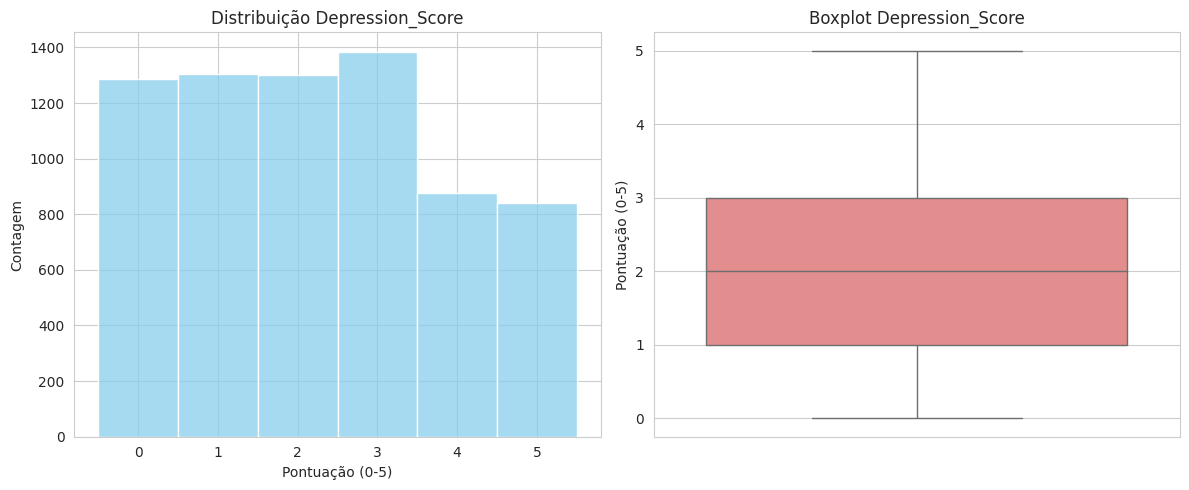


--- Variáveis Preditivas Numéricas (EDA) ---
Estatísticas Descritivas:
|       |   Semester_Credit_Load |   Financial_Stress |        CGPA |
|:------|-----------------------:|-------------------:|------------:|
| count |             6995       |         6995       | 6995        |
| mean  |               22.011   |            2.45347 |    3.49125  |
| std   |                4.36057 |            1.70935 |    0.287363 |
| min   |               15       |            0       |    2.44     |
| 25%   |               18       |            1       |    3.29     |
| 50%   |               22       |            2       |    3.5      |
| 75%   |               26       |            4       |    3.7      |
| max   |               29       |            5       |    4        |


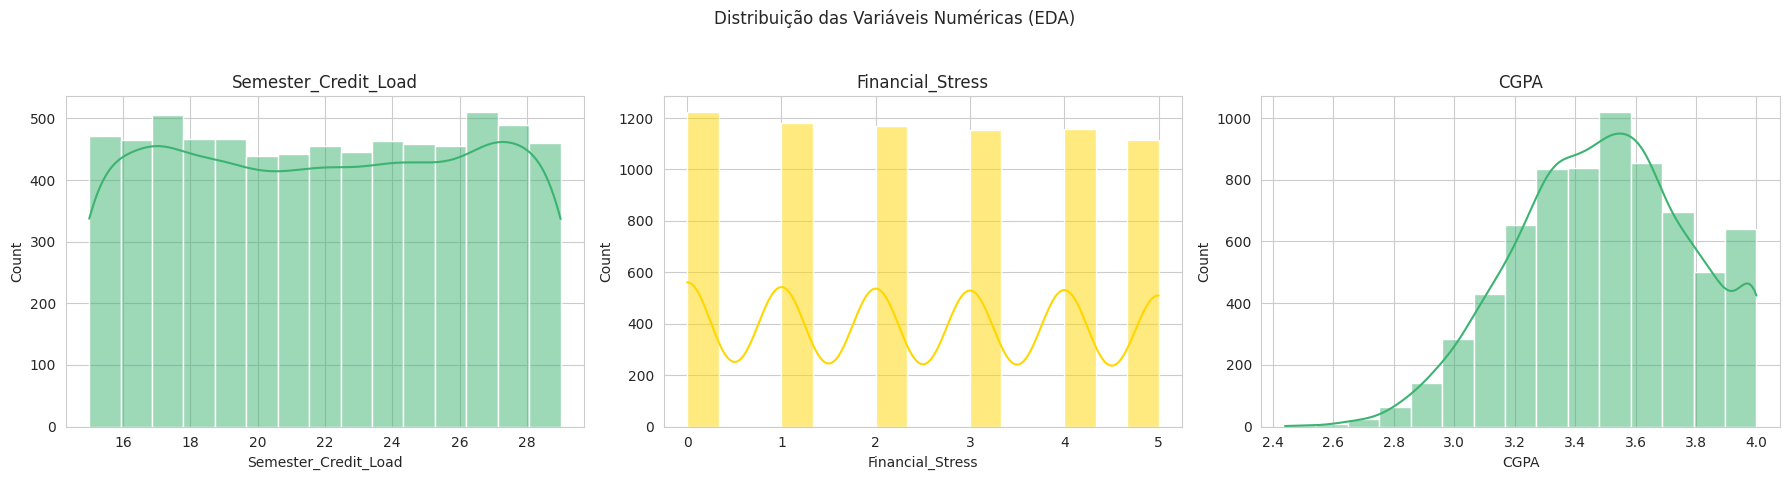


--- Variáveis Preditivas Ordinais (Codificadas) ---
Distribuição (Contagem):


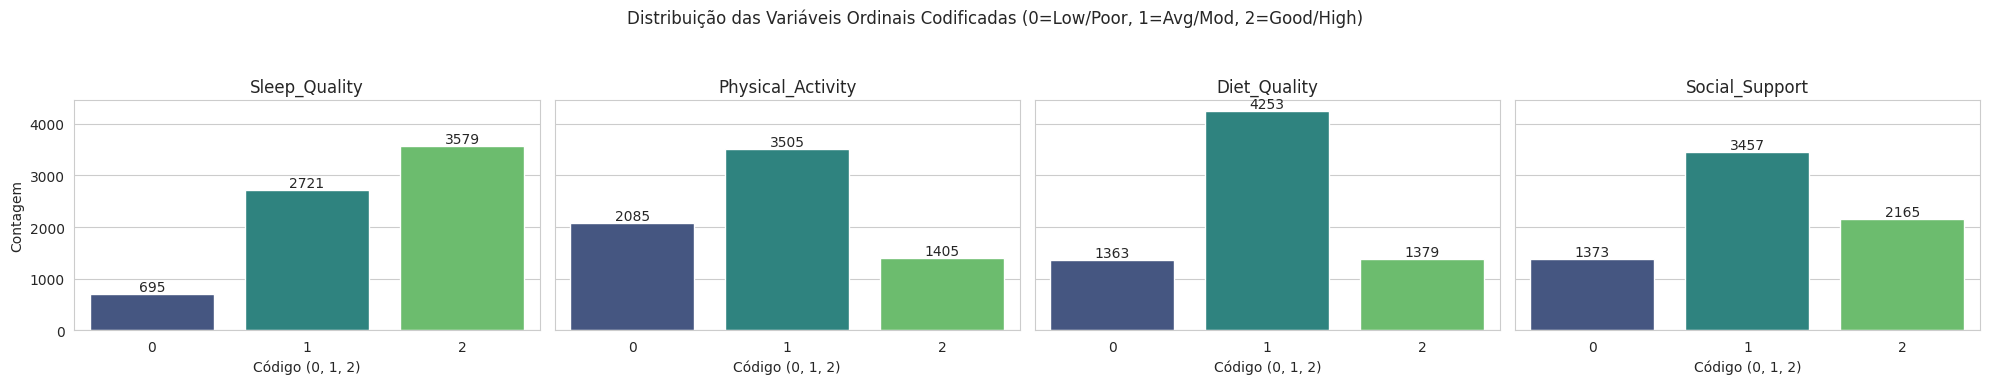


--- Outras Variáveis Categóricas (Distribuição Original) ---


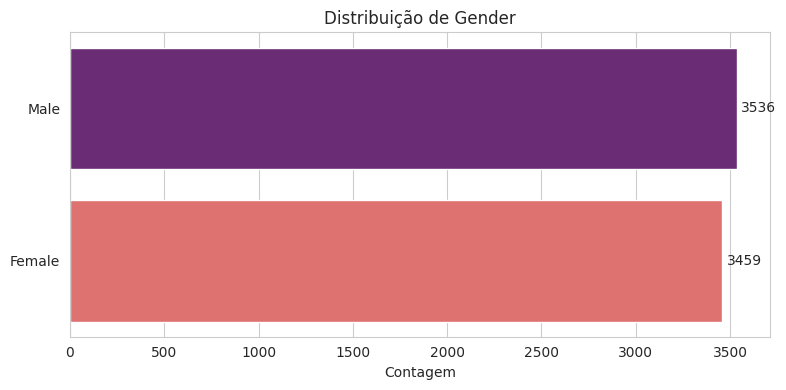

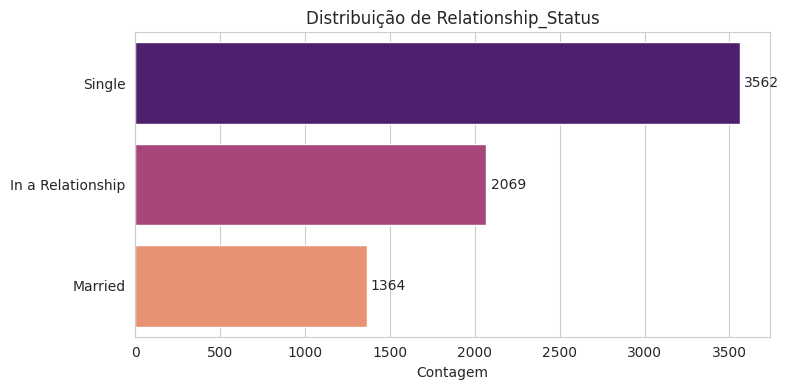

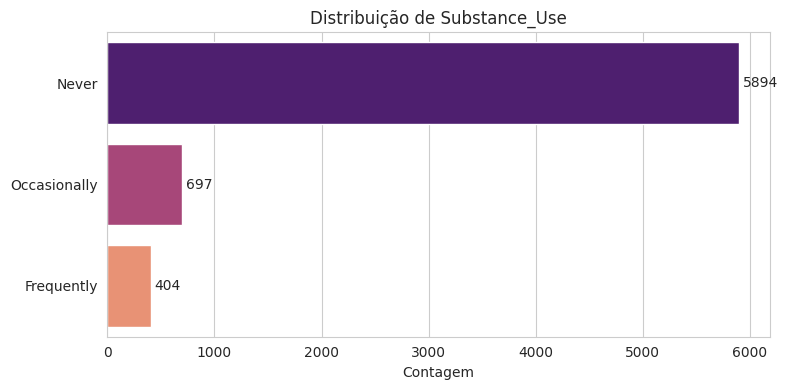

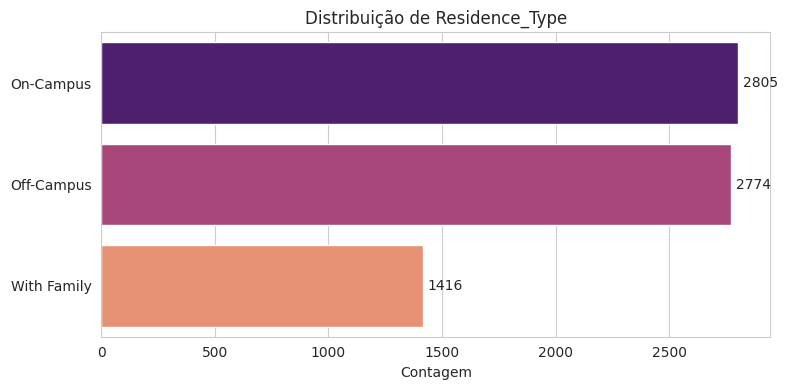

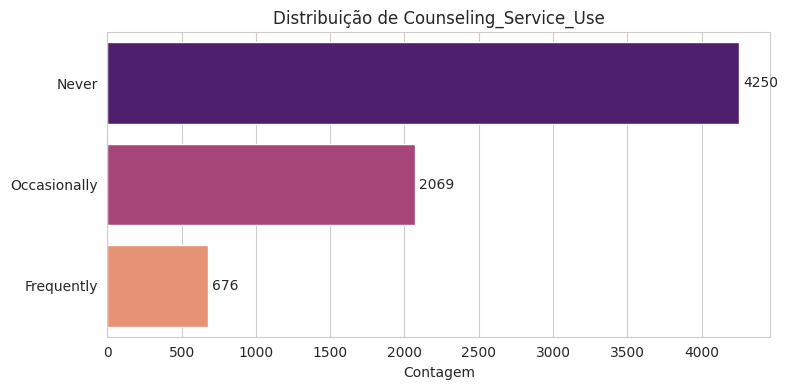

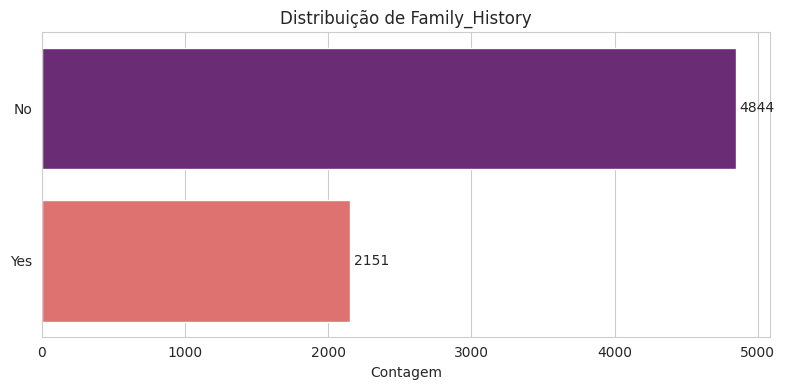

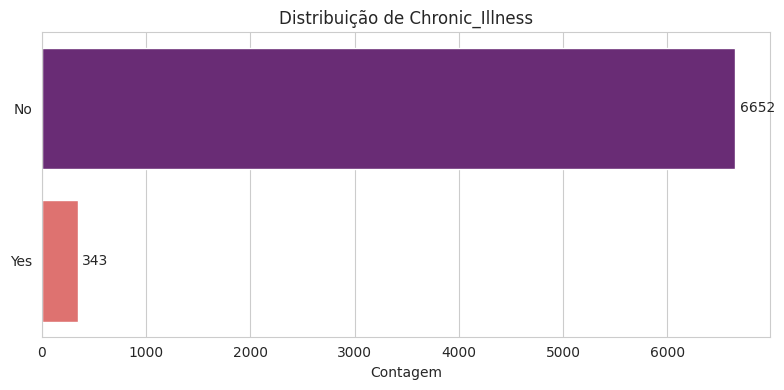

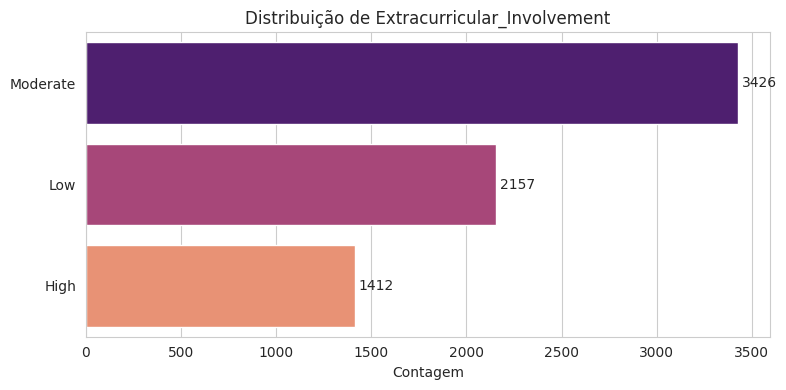

In [8]:
# Variável Alvo: Depression_Score
print("\n--- Variável Alvo: Depression_Score ---")
target_col = 'Depression_Score'
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
    print("Estatísticas Descritivas:")
    print(df[target_col].describe().to_markdown())
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[target_col], kde=False, bins=df[target_col].nunique(), discrete=True, color='skyblue')
    plt.title(f'Distribuição {target_col}')
    plt.xlabel('Pontuação (0-5)')
    plt.ylabel('Contagem')
    plt.xticks(sorted(df[target_col].unique().astype(int)))

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[target_col], color='lightcoral')
    plt.title(f'Boxplot {target_col}')
    plt.ylabel('Pontuação (0-5)')
    plt.tight_layout(); plt.show()
else:
    print(f"Coluna '{target_col}' não encontrada ou não numérica.")

# Variáveis Preditivas Numéricas (INCLUINDO CGPA para EDA)
print("\n--- Variáveis Preditivas Numéricas (EDA) ---")
numeric_predictors_eda = ['Semester_Credit_Load', 'Financial_Stress', 'CGPA'] # CGPA incluído aqui para EDA
valid_numeric_predictors_eda = [col for col in numeric_predictors_eda if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
if valid_numeric_predictors_eda:
    print("Estatísticas Descritivas:")
    print(df[valid_numeric_predictors_eda].describe().to_markdown())
    n_cols = len(valid_numeric_predictors_eda)
    fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5))
    if n_cols == 1: axes = [axes]
    fig.suptitle("Distribuição das Variáveis Numéricas (EDA)")
    for i, col in enumerate(valid_numeric_predictors_eda):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=15, color='mediumseagreen' if i%2==0 else 'gold')
        axes[i].set_title(col)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
    print(f"Nenhuma das colunas {numeric_predictors_eda} foi encontrada ou é numérica.")


# Variáveis Preditivas Ordinais (Codificadas)
print("\n--- Variáveis Preditivas Ordinais (Codificadas) ---")
ordinal_predictors = ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support']
valid_ordinal_predictors = [col for col in ordinal_predictors if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
if valid_ordinal_predictors:
    print("Distribuição (Contagem):")
    n_cols = len(valid_ordinal_predictors)
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4), sharey=True)
    if n_cols == 1: axes = [axes]
    fig.suptitle("Distribuição das Variáveis Ordinais Codificadas (0=Low/Poor, 1=Avg/Mod, 2=Good/High)")
    for i, col in enumerate(valid_ordinal_predictors):
        ax = sns.countplot(x=df[col].astype(int), ax=axes[i], palette='viridis', order=sorted(df[col].unique().astype(int)))
        ax.set_title(col)
        ax.set_xlabel("Código (0, 1, 2)")
        ax.set_ylabel("Contagem" if i==0 else "")
        for container in ax.containers:
            ax.bar_label(container)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93]); plt.show()
else:
     print(f"Nenhuma das colunas {ordinal_predictors} foi encontrada ou é numérica.")


# Outras Variáveis Categóricas Originais (Exemplo) - Distribuição
print("\n--- Outras Variáveis Categóricas (Distribuição Original) ---")
other_categorical_cols = ['Gender', 'Relationship_Status', 'Substance_Use', 'Residence_Type',
                          'Counseling_Service_Use', 'Family_History', 'Chronic_Illness',
                          'Extracurricular_Involvement']
for col in other_categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(8, max(4, df[col].nunique()*0.5) ))
        ax = sns.countplot(y=df[col], order = df[col].value_counts().index, palette='magma')
        plt.title(f'Distribuição de {col}')
        plt.xlabel('Contagem')
        plt.ylabel('')
        for container in ax.containers:
           ax.bar_label(container, label_type='edge', padding=3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Aviso: Coluna '{col}' não encontrada.")

### 3.2 Análise Bivariada


--- Depression_Score vs. Variáveis Numéricas (EDA) ---
Correlação entre Depression_Score e Semester_Credit_Load: 0.023 <<--- OBSERVE O SINAL AQUI
Correlação entre Depression_Score e Financial_Stress: -0.012 <<--- OBSERVE O SINAL AQUI
Correlação entre Depression_Score e CGPA: -0.022 <<--- OBSERVE O SINAL AQUI


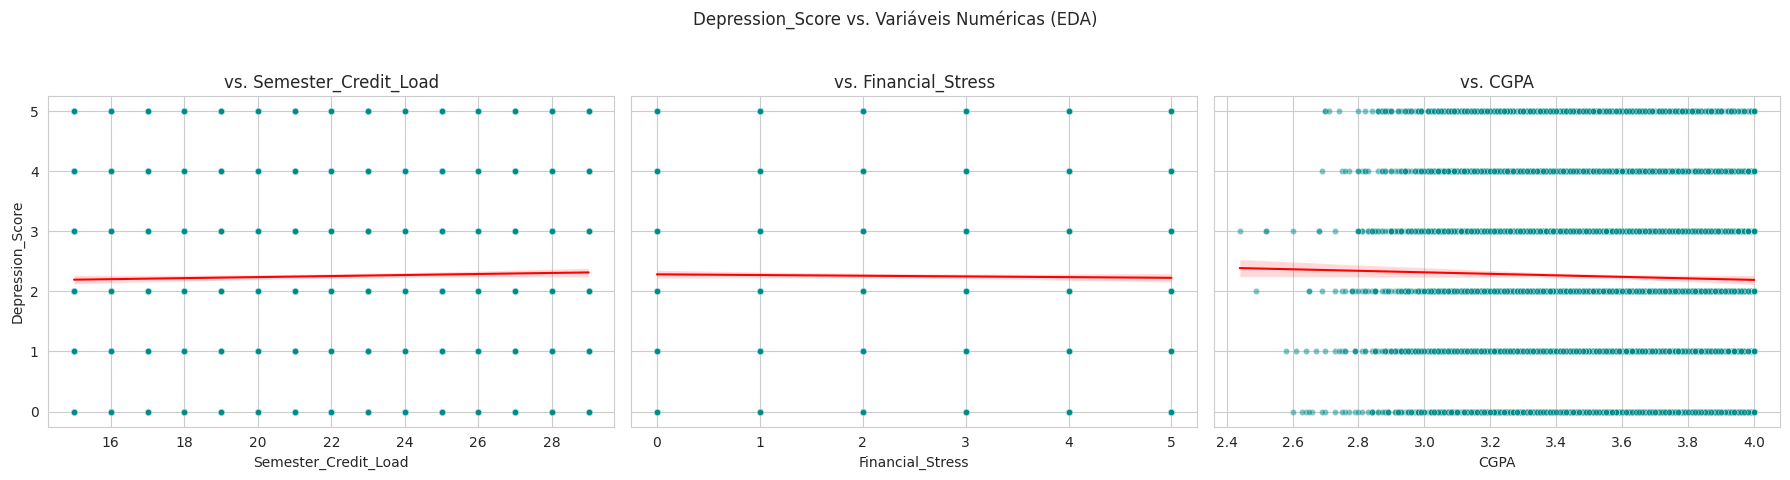


--- Depression_Score vs. Variáveis Ordinais Selecionadas ---
Média Depression_Score por Sleep_Quality:
|   Sleep_Quality |   Depression_Score |
|----------------:|-------------------:|
|               0 |            2.27626 |
|               1 |            2.26314 |
|               2 |            2.24504 |
 <<--- OBSERVE A TENDÊNCIA AQUI
Média Depression_Score por Physical_Activity:
|   Physical_Activity |   Depression_Score |
|--------------------:|-------------------:|
|                   0 |            2.22542 |
|                   1 |            2.26505 |
|                   2 |            2.27473 |
 <<--- OBSERVE A TENDÊNCIA AQUI
Média Depression_Score por Diet_Quality:
|   Diet_Quality |   Depression_Score |
|---------------:|-------------------:|
|              0 |            2.29347 |
|              1 |            2.21444 |
|              2 |            2.343   |
 <<--- OBSERVE A TENDÊNCIA AQUI
Média Depression_Score por Social_Support:
|   Social_Support |   Depression_Score 

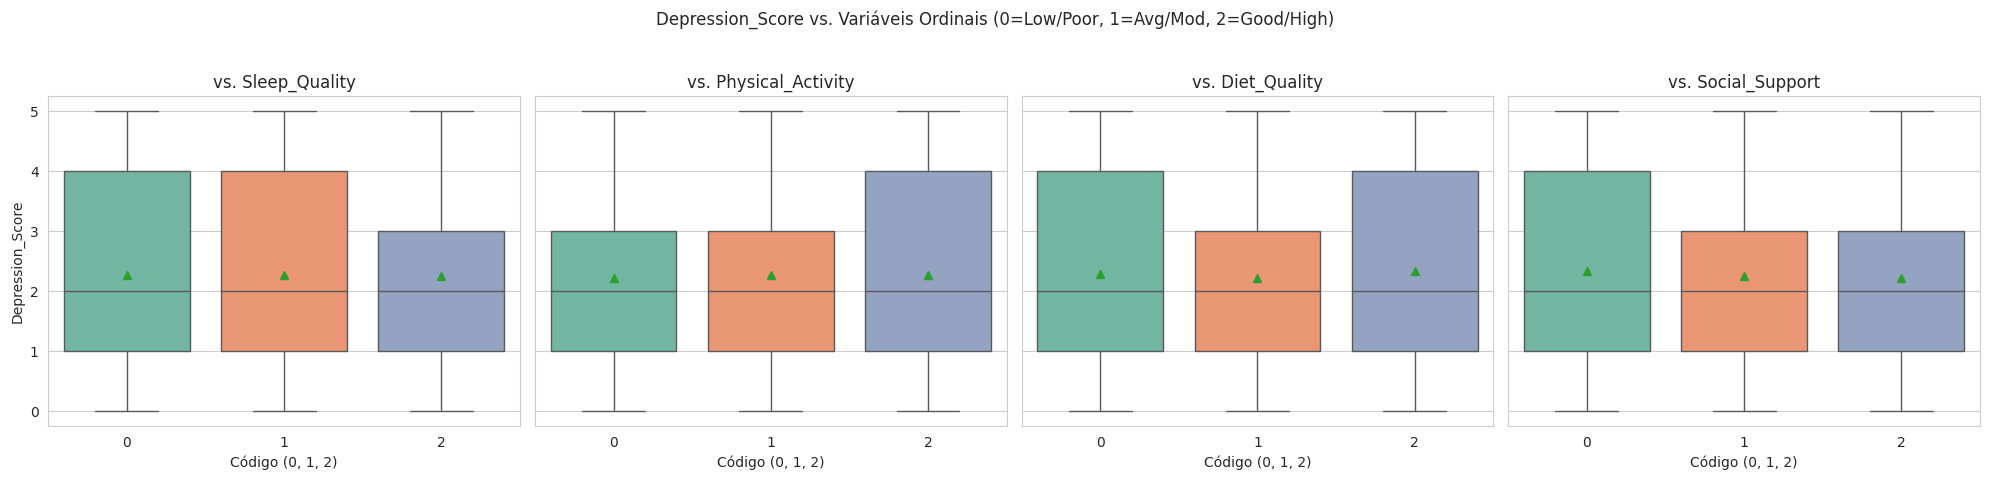


--- Depression_Score vs. Course (Original) ---


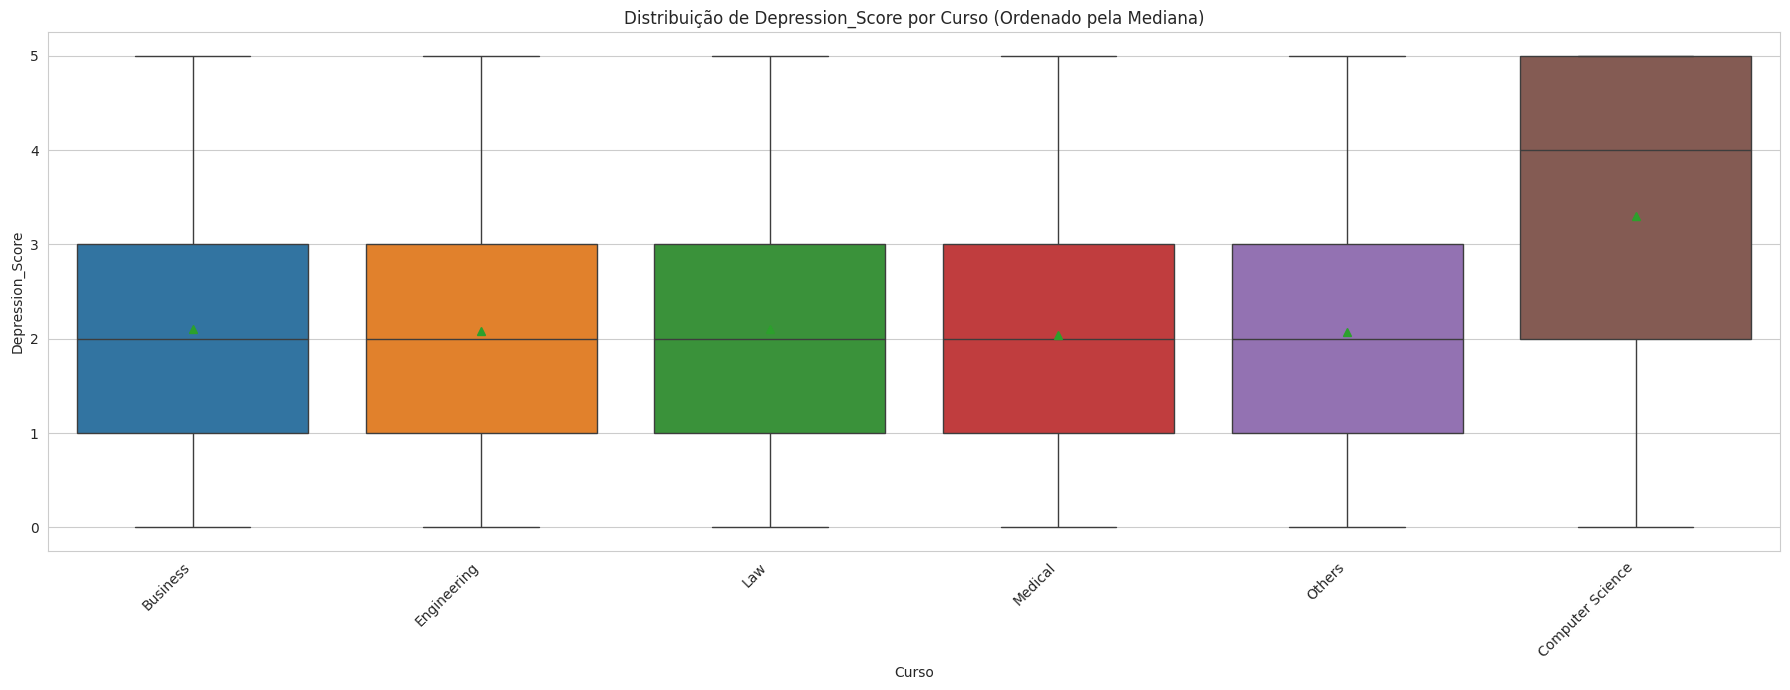


Média, Mediana e Contagem de Depression_Score por Curso (Ordenado pela Média):
| Course           |    mean |   median |   count |
|:-----------------|--------:|---------:|--------:|
| Computer Science | 3.30235 |        4 |    1022 |
| Business         | 2.10629 |        2 |     715 |
| Law              | 2.10065 |        2 |    1381 |
| Engineering      | 2.08622 |        2 |    1067 |
| Others           | 2.07563 |        2 |     714 |
| Medical          | 2.04437 |        2 |    2096 |

--- Matriz de Correlação (Heatmap - EDA) --- 
Calculando correlação (EDA) para as colunas: ['CGPA', 'Depression_Score', 'Diet_Quality', 'Financial_Stress', 'Physical_Activity', 'Semester_Credit_Load', 'Sleep_Quality', 'Social_Support']


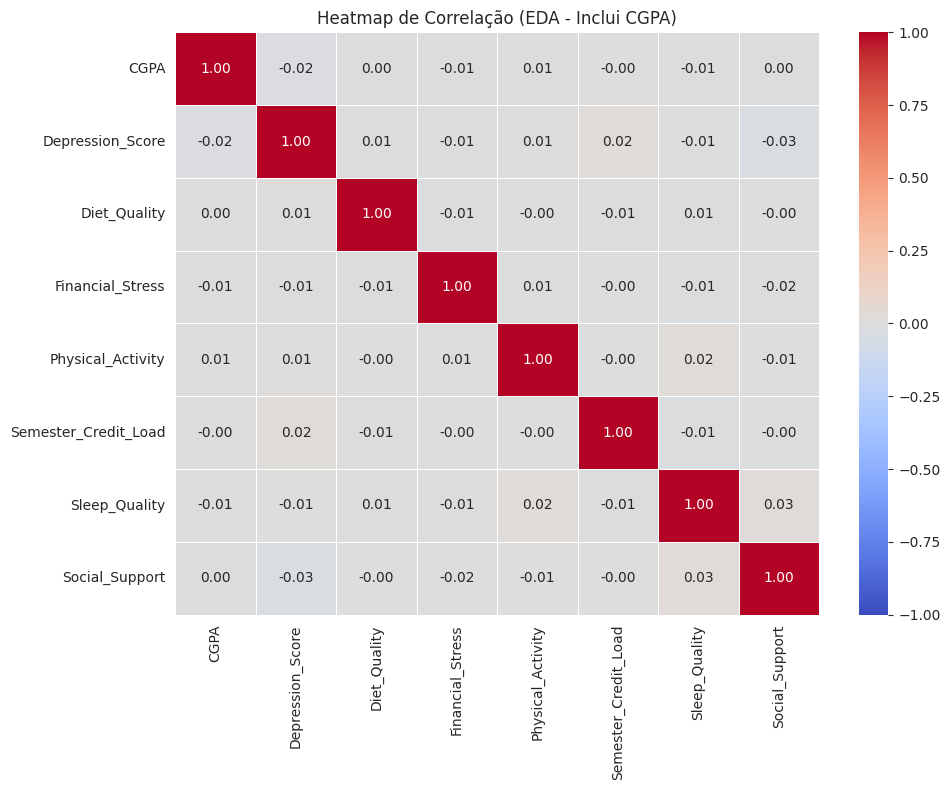


<<--- OBSERVE OS SINAIS (+/-) NA LINHA/COLUNA 'Depression_Score' AQUI


In [9]:
# Alvo vs. Preditores Numéricos (INCLUINDO CGPA para EDA)
print("\n--- Depression_Score vs. Variáveis Numéricas (EDA) ---")
target_col = 'Depression_Score'
# Usa a lista valid_numeric_predictors_eda definida na célula anterior
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]) and valid_numeric_predictors_eda:
    n_cols = len(valid_numeric_predictors_eda)
    fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5), sharey=True)
    if n_cols == 1: axes = [axes]
    fig.suptitle(f'{target_col} vs. Variáveis Numéricas (EDA)')
    for i, col in enumerate(valid_numeric_predictors_eda):
        sns.scatterplot(x=df[col], y=df[target_col], alpha=0.5, ax=axes[i], s=20, color='darkcyan')
        sns.regplot(x=df[col], y=df[target_col], scatter=False, color='red', line_kws={'linewidth': 1.5}, ax=axes[i])
        axes[i].set_title(f'vs. {col}')
        axes[i].set_ylabel(target_col if i==0 else '')
        # Calcular correlação de Pearson
        corr_val = df[col].corr(df[target_col])
        print(f"Correlação entre {target_col} e {col}: {corr_val:.3f} <<--- OBSERVE O SINAL AQUI") # Imprime correlação
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
     print(f"Aviso: '{target_col}' ou colunas numéricas (EDA) não encontradas/válidas.")


# Alvo vs. Preditores Ordinais (Codificados)
print("\n--- Depression_Score vs. Variáveis Ordinais Selecionadas ---")
# Reutiliza valid_ordinal_predictors
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]) and valid_ordinal_predictors:
    n_cols = len(valid_ordinal_predictors)
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5), sharey=True)
    if n_cols == 1: axes = [axes]
    fig.suptitle(f'{target_col} vs. Variáveis Ordinais (0=Low/Poor, 1=Avg/Mod, 2=Good/High)')
    for i, col in enumerate(valid_ordinal_predictors):
        sns.boxplot(x=df[col].astype(int), y=df[target_col], ax=axes[i], palette='Set2', showmeans=True)
        axes[i].set_title(f'vs. {col}')
        axes[i].set_xlabel("Código (0, 1, 2)")
        axes[i].set_ylabel(target_col if i==0 else '')
        means = df.groupby(df[col].astype(int))[target_col].mean()
        print(f"Média {target_col} por {col}:\n{means.to_markdown()}\n <<--- OBSERVE A TENDÊNCIA AQUI")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
     print(f"Aviso: '{target_col}' ou colunas ordinais não encontradas/válidas.")


# Alvo vs. Cursos (Usando DataFrame Original)
print("\n--- Depression_Score vs. Course (Original) ---")
try:
    df_orig = pd.read_csv(file_path)
    cols_with_nan_orig = ['CGPA', 'Substance_Use']
    df_orig.dropna(subset=cols_with_nan_orig + ['Course', target_col], inplace=True)

    if not df_orig.empty and 'Course' in df_orig.columns and target_col in df_orig.columns:
      plt.figure(figsize=(18, 7))
      order = df_orig.groupby('Course')[target_col].median().sort_values().index
      sns.boxplot(x='Course', y=target_col, data=df_orig, order=order, palette='tab10', showmeans=True)
      plt.title(f'Distribuição de {target_col} por Curso (Ordenado pela Mediana)')
      plt.xticks(rotation=45, ha='right')
      plt.ylabel(f'{target_col}')
      plt.xlabel('Curso')
      plt.tight_layout()
      plt.show()

      print(f"\nMédia, Mediana e Contagem de {target_col} por Curso (Ordenado pela Média):")
      agg_results = df_orig.groupby('Course')[target_col].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
      print(agg_results.to_markdown())
      del df_orig
    else:
      print("DataFrame original vazio ou colunas 'Course'/'Depression_Score' ausentes após limpeza.")

except FileNotFoundError:
    print("Arquivo original não encontrado para gerar gráfico por curso.")
except Exception as e:
    print(f"Erro ao gerar gráfico por curso original: {e}")


# Correlação entre Variáveis Numéricas e Ordinais Selecionadas (INCLUINDO CGPA para EDA)
print("\n--- Matriz de Correlação (Heatmap - EDA) --- ")
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
    # Usa a lista `valid_numeric_predictors_eda` que inclui CGPA
    cols_for_corr_eda = valid_numeric_predictors_eda + valid_ordinal_predictors + [target_col]
    cols_for_corr_eda = sorted(list(set(cols_for_corr_eda)))
    valid_cols_for_corr_eda = [col for col in cols_for_corr_eda if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    if len(valid_cols_for_corr_eda) > 1:
        print(f"Calculando correlação (EDA) para as colunas: {valid_cols_for_corr_eda}")
        correlation_matrix_eda = df[valid_cols_for_corr_eda].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix_eda, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
        plt.title('Heatmap de Correlação (EDA - Inclui CGPA)')
        plt.tight_layout()
        plt.show()
        print("\n<<--- OBSERVE OS SINAIS (+/-) NA LINHA/COLUNA 'Depression_Score' AQUI")
    else:
        print("Não há colunas suficientes encontradas/válidas para gerar heatmap (EDA).")
else:
    print(f"Coluna '{target_col}' não encontrada ou não numérica para correlação (EDA)." )

## 4. Modelagem Inicial: Regressão Linear Múltipla (Com CGPA)


In [10]:
# --- Seleção de Features ---
# Usaremos as listas 'valid_*' da EDA '
feature_cols = valid_ordinal_predictors + valid_numeric_predictors_eda + [col for col in df.columns if col.startswith('Course_')]
target_col = 'Depression_Score'

print(f"\nVariáveis preditoras (Features) selecionadas para o MODELO ({len(feature_cols)}):")
if len(feature_cols) > 10:
    print(f"  {feature_cols[:5]} ... {feature_cols[-5:]}")
else:
    print(f"  {feature_cols}")
print(f"\nVariável Alvo: {target_col}")

# --- Verificações Cruciais ---
if not feature_cols:
    raise ValueError("A lista de features está vazia. Verifique o pré-processamento.")
missing_features = [col for col in feature_cols if col not in df.columns]
if missing_features:
    raise ValueError(f"Features ausentes no DataFrame final: {missing_features}")
if target_col not in df.columns or not pd.api.types.is_numeric_dtype(df[target_col]):
     raise ValueError(f"Variável alvo '{target_col}' ausente ou inválida.")

X = df[feature_cols]
y = df[target_col]




Variáveis preditoras (Features) selecionadas para o MODELO (12):
  ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Semester_Credit_Load'] ... ['Course_Computer Science', 'Course_Engineering', 'Course_Law', 'Course_Medical', 'Course_Others']

Variável Alvo: Depression_Score


In [11]:
# --- 4.2 Divisão Treino/Teste ---
print("\nDividindo dados em treino/teste (80/20, random_state=42)...")
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"  Tamanho Treino: {X_train.shape[0]} amostras ({len(X_train.columns)} features)")
    print(f"  Tamanho Teste:  {X_test.shape[0]} amostras")
except Exception as e:
    print(f"Erro durante a divisão treino/teste: {e}")
    raise SystemExit()




Dividindo dados em treino/teste (80/20, random_state=42)...
  Tamanho Treino: 5596 amostras (12 features)
  Tamanho Teste:  1399 amostras


In [15]:
# --- 4.3 Treinamento do Modelo ---
print("\nTreinando o modelo LinearRegression.")
model = LinearRegression()
try:
    model.fit(X_train, y_train)
    print("  Modelo treinado com sucesso.")
except Exception as e:
    print(f"Erro durante o treinamento: {e}")
    raise SystemExit()


Treinando o modelo LinearRegression.
  Modelo treinado com sucesso.



--- Avaliação do Modelo (Conjunto de Teste) ---
  R² (Coef. de Determinação): 0.0782
  MAE (Erro Absoluto Médio):  1.3020
  MSE (Erro Quadrático Médio): 2.4188
  RMSE (Raiz do EQM):        1.5552

  Interpretação:
    -> R² indica que ~7.8% da variabilidade de 'Depression_Score' é explicada por este modelo.
    -> Em média, o modelo erra a previsão em ~1.30 pontos (MAE) ou ~1.56 pontos (RMSE) na escala 0-5.


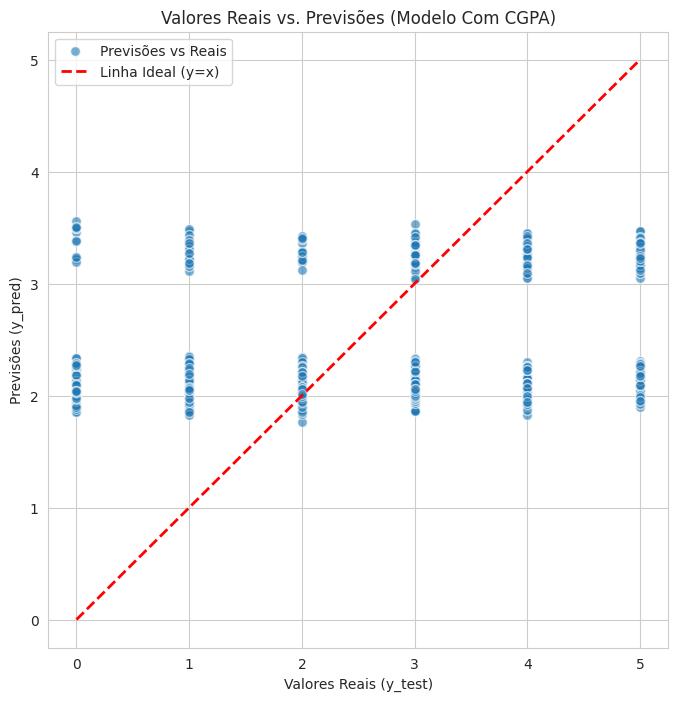

In [13]:
# --- 4.4 Avaliação do Modelo ---
print("\n--- Avaliação do Modelo (Conjunto de Teste) ---")
try:
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"  R² (Coef. de Determinação): {r2:.4f}")
    print(f"  MAE (Erro Absoluto Médio):  {mae:.4f}")
    print(f"  MSE (Erro Quadrático Médio): {mse:.4f}")
    print(f"  RMSE (Raiz do EQM):        {rmse:.4f}")
    print("\n  Interpretação:")
    print(f"    -> R² indica que ~{r2*100:.1f}% da variabilidade de '{target_col}' é explicada por este modelo.")
    print(f"    -> Em média, o modelo erra a previsão em ~{mae:.2f} pontos (MAE) ou ~{rmse:.2f} pontos (RMSE) na escala 0-5.")

    # Gráfico de Previsões vs. Reais
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', s=50, label='Previsões vs Reais')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', lw=2, color='red', label='Linha Ideal (y=x)')
    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Previsões (y_pred)")
    plt.title("Valores Reais vs. Previsões (Modelo Com CGPA)")
    plt.legend()
    plt.grid(True); plt.show()

except Exception as e:
    print(f"Erro durante a avaliação ou plotagem: {e}")




--- Análise dos Coeficientes (Modelo Com CGPA) --- 

Coeficientes (β) do modelo treinado:
| Feature                 |   Coefficient |
|:------------------------|--------------:|
| Intercepto (β0)         |        2.4654 |
| Sleep_Quality           |       -0.002  |
| Physical_Activity       |        0.0073 |
| Diet_Quality            |        0.0378 |
| Social_Support          |       -0.0693 |
| Semester_Credit_Load    |        0.0122 |
| Financial_Stress        |       -0.0275 |
| CGPA                    |       -0.1456 |
| Course_Computer Science |        1.1555 |
| Course_Engineering      |       -0.0441 |
| Course_Law              |        0.0021 |
| Course_Medical          |       -0.0538 |
| Course_Others           |       -0.051  |

<<--- OBSERVE OS SINAIS DOS COEFICIENTES PARA CGPA, Physical_Activity, Diet_Quality AQUI


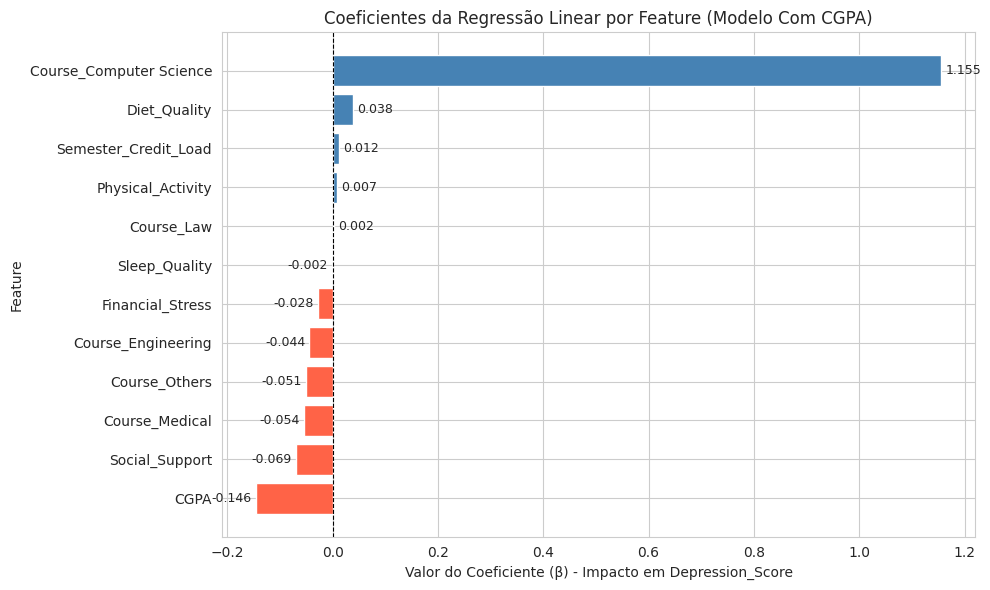


  Interpretação do Gráfico:
    - Barras Azuis (>0): Aumento na feature -> Aumento na previsão de Depressão.
    - Barras Vermelhas (<0): Aumento na feature -> Diminuição na previsão de Depressão.
    -> Verifique os sinais para 'CGPA', 'Physical_Activity' e 'Diet_Quality'. São negativos como esperado?
    - Comprimento da Barra: Magnitude do efeito *nesta escala*.
    - Cuidado: Comparação direta requer padronização prévia.


In [14]:
# --- 4.5 Análise dos Coeficientes ---
print("\n--- Análise dos Coeficientes (Modelo Com CGPA) --- ")
try:
    coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
    intercept_df = pd.DataFrame({'Feature': ['Intercepto (β0)'], 'Coefficient': [model.intercept_]})
    coefficients = pd.concat([intercept_df, coefficients]).reset_index(drop=True)

    print("\nCoeficientes (β) do modelo treinado:")
    print(coefficients.round(4).to_markdown(index=False))
    print("\n<<--- OBSERVE OS SINAIS DOS COEFICIENTES PARA CGPA, Physical_Activity, Diet_Quality AQUI")

    # Visualização da Magnitude dos Coeficientes (sem intercepto)
    plt.figure(figsize=(10, max(6, len(feature_cols)*0.35)))
    coef_plot_df = coefficients[coefficients['Feature'] != 'Intercepto (β0)'].copy()
    coef_plot_df = coef_plot_df.sort_values(by='Coefficient', ascending=True)
    colors = ['tomato' if c < 0 else 'steelblue' for c in coef_plot_df['Coefficient']]

    bars = plt.barh(coef_plot_df['Feature'], coef_plot_df['Coefficient'], color=colors)
    plt.title('Coeficientes da Regressão Linear por Feature (Modelo Com CGPA)')
    plt.xlabel('Valor do Coeficiente (β) - Impacto em Depression_Score')
    plt.ylabel('Feature')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    plt.bar_label(bars, fmt='%.3f', padding=3, fontsize=9)
    plt.tight_layout(); plt.show()

    print("\n  Interpretação do Gráfico:")
    print("    - Barras Azuis (>0): Aumento na feature -> Aumento na previsão de Depressão.")
    print("    - Barras Vermelhas (<0): Aumento na feature -> Diminuição na previsão de Depressão.")
    print("    -> Verifique os sinais para 'CGPA', 'Physical_Activity' e 'Diet_Quality'. São negativos como esperado?")
    print("    - Comprimento da Barra: Magnitude do efeito *nesta escala*.")
    print("    - Cuidado: Comparação direta requer padronização prévia.")

except Exception as e:
    print(f"Erro ao analisar ou plotar coeficientes: {e}")